# Import Libraries & Models

In [1]:
from datetime import datetime
from dotenv import load_dotenv
import pandas as pd
pd.set_option('display.max_rows', 1000)
import os
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(10,3)})
import numpy as np
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

# Internal
import utils

# Read Sensor Data

In [2]:
# Read sensor data
file_path_s = "./field_data/sensor.csv"
df_s = pd.read_csv(file_path_s)
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SensorID   23 non-null     object 
 1   SensorSN   18 non-null     float64
 2   Depth      8 non-null      float64
 3   SurfaceEl  23 non-null     float64
 4   SensorEl   23 non-null     float64
 5   A          18 non-null     float64
 6   B          8 non-null      float64
 7   C          8 non-null      float64
dtypes: float64(7), object(1)
memory usage: 1.6+ KB


In [3]:
sensor_file = df_s.to_dict(orient="records")
# sensor_file

# Read Well Data

In [4]:
# Read well data
file_path_well = "./field_data/bcd_data.csv"
df_w = pd.read_csv(file_path_well, skiprows=1)
# dfs["DATE"] = pd.to_datetime(dfs["DATE"], unit="D", origin="1899-12-30")
df_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        724 non-null    object 
 1   Water_Elev  724 non-null    float64
 2   1A          698 non-null    float64
 3   2A          697 non-null    float64
 4   3A          703 non-null    float64
 5   3B          703 non-null    float64
 6   4A          703 non-null    float64
 7   4B          703 non-null    float64
 8   6A          698 non-null    float64
 9   6B          698 non-null    float64
 10  9A          698 non-null    float64
 11  10A         703 non-null    float64
 12  PH11        657 non-null    float64
 13  PH12        661 non-null    float64
 14  PH13        663 non-null    float64
 15  PH14        633 non-null    float64
 16  P19B        135 non-null    float64
dtypes: float64(16), object(1)
memory usage: 96.3+ KB


In [5]:
# Read vwp data
file_path_vwp = "./field_data/bcd_vwp_data.csv"
df_vw = pd.read_csv(file_path_vwp)
df_vw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    121 non-null    object 
 1   P15     120 non-null    float64
 2   P16     121 non-null    float64
 3   P17     121 non-null    float64
 4   P18U    121 non-null    float64
 5   P18L    121 non-null    float64
 6   P19U    121 non-null    float64
 7   P19L    121 non-null    float64
 8   P20     121 non-null    float64
dtypes: float64(8), object(1)
memory usage: 51.2+ KB


In [6]:
df_vw.head()

,Date,P15,P16,P17,P18U,P18L,P19U,P19L,P20
0,8/28/2009,2939.7,2902.7,2947.4,2814.2,2833.3,2856.1,2868.6,2767.5
1,9/28/2009,2939.8,2902.4,2947.6,2814.4,2833.4,2856.9,2868.5,2767.8
2,10/29/2009,2939.2,2901.8,2947.8,2813.8,2833.3,2855.6,2868.2,2767.8
3,11/30/2009,2939.1,2901.6,2948.4,2813.8,2833.1,2855.6,2868.0,2768.2
4,12/31/2009,2939.4,2901.5,2948.8,2815.2,2832.7,2854.6,2867.9,2768.3


In [7]:
# Merge well and vw dataframe, union keys from both df
dfs = pd.merge(df_w, df_vw, how="outer")

# Drop row # 101 as known wrong format: 10/??/2004
dfs.drop(labels=101, axis=0, inplace=True)

# Parse "Date" column
dfs['Date'] = pd.to_datetime(dfs['Date'])
# dfs['Date'] = pd.to_datetime(dfs['Date'], format = '%m/%d/%Y')
dfs = dfs.sort_values(by="Date")

# Drop data after 2019/6/27
i = dfs[dfs["Date"] > "2019-06-27"].index
dfs.drop(i, axis=0, inplace=True)
dfs.reset_index()

# Drop "NaT" rows
dfs.dropna(subset="Date", axis=0, inplace=True)

dfs.tail()

,Date,Water_Elev,1A,2A,3A,3B,4A,4B,6A,6B,...,PH14,P19B,P15,P16,P17,P18U,P18L,P19U,P19L,P20
241,2019-02-22,422.04,29.0,72.0,100.0,57.0,130.0,27.0,75.0,26.0,...,40.5,27.37,2898.2,2852.2,2947.4,2808.8,2817.6,2839.2,2841.1,2757.3
332,2019-03-29,422.31,28.0,70.0,103.0,85.0,138.0,25.0,73.0,24.0,...,40.5,28.09,2890.5,2847.1,2944.0,2807.8,2816.2,2839.1,2840.3,2753.6
409,2019-04-29,421.18,27.0,69.0,100.0,38.0,125.0,28.0,78.0,27.0,...,40.5,28.27,2901.3,2853.6,2939.9,2807.9,2817.5,2840.4,2841.1,2758.1
452,2019-05-23,420.17,28.0,72.0,102.0,15.0,122.0,32.0,78.0,30.0,...,40.5,29.35,2908.3,2858.7,2937.3,2808.2,2817.6,2843.6,2845.0,2759.0
537,2019-06-27,418.12,26.0,62.0,96.0,13.0,118.0,27.0,72.0,25.0,...,40.5,29.82,2907.8,2856.7,2935.8,2808.3,2818.7,2847.5,2850.9,2761.1


# Data Visualization and Resampling
Based on the well data above, we see that the non-null values vary from 120 to 724, meaning that there are missing data all over the place. We will focus mainly on the water elevation. So, below, we plot the original data, then resample the dataset to weekly and monthly data. With monthly-spaced data, the line is smoothened. Further below, the weekly-spaced dataset appear to have continuous missing values in the next few data points. This makes the weekly data less meaningful as we have to guess the three missing values in a row, instead of averaging or interpolating between the previous and the next values.  

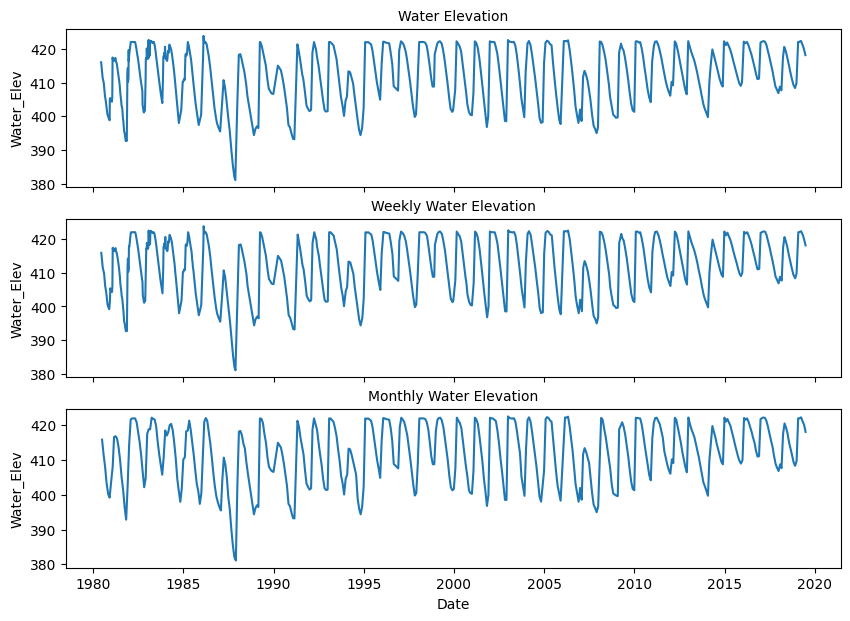

In [8]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(10,7))

sns.lineplot(x=dfs["Date"], y=dfs["Water_Elev"], ax=ax[0])
ax[0].set_title("Water Elevation", fontsize=10)

resampled_dfs = dfs[["Date", "Water_Elev"]].resample("W", on="Date").mean().reset_index()
sns.lineplot(x=resampled_dfs["Date"], y=resampled_dfs["Water_Elev"], ax=ax[1])
ax[1].set_title("Weekly Water Elevation", fontsize=10)

resampled_dfs = dfs[["Date", "Water_Elev"]].resample("ME", on="Date").mean().reset_index()
sns.lineplot(x=resampled_dfs["Date"], y=resampled_dfs["Water_Elev"], ax=ax[2])
ax[2].set_title("Monthly Water Elevation", fontsize=10)

plt.show()

In [9]:
# Create a weekly water elevation dateset
dfs_wk = dfs[["Date", "Water_Elev"]].resample("W", on="Date").mean().reset_index(drop=False)

# Check time intervals
dfs_wk["delta"] = dfs_wk["Date"] - dfs_wk["Date"].shift(1)
dfs_wk[["Date", "Water_Elev", "delta"]]

,Date,Water_Elev,delta
0,1980-06-15,415.90,NaT
1,1980-06-22,NaN,7 days
2,1980-06-29,NaN,7 days
3,1980-07-06,NaN,7 days
4,1980-07-13,411.60,7 days
...,...,...,...
2033,2019-06-02,NaN,7 days
2034,2019-06-09,NaN,7 days
2035,2019-06-16,NaN,7 days
2036,2019-06-23,NaN,7 days


In [10]:
# Create a monthly water elevation dateset
dfs_mo = dfs[["Date", "Water_Elev"]].resample("ME", on="Date").mean().reset_index(drop=False)

# Check time intervals
dfs_mo["delta"] = dfs_mo["Date"] - dfs_mo["Date"].shift(1)
dfs_mo[["Date", "Water_Elev", "delta"]].head(75)

,Date,Water_Elev,delta
0,1980-06-30,415.900000,NaT
1,1980-07-31,411.600000,31 days
2,1980-08-31,408.000000,31 days
3,1980-09-30,403.350000,30 days
4,1980-10-31,400.250000,31 days
5,1980-11-30,399.200000,30 days
6,1980-12-31,403.820000,31 days
7,1981-01-31,408.025000,31 days
8,1981-02-28,416.650000,28 days
9,1981-03-31,416.875000,31 days


# Data Processing
Even though we downsized the data from weekly to monthly, there appears to be some months when there are no data. We can sum all the "NaN" values, resulting in 36 missing values in the entire monthly dataset. There are several ways to fill in the missing values. Here, we interpolate the missing values using the previous and next values. 

In [11]:
# Now we can drop "delta" and find NaN within the monthly dataset
dfs_mo.drop('delta', axis=1, inplace=True)
dfs_mo.isna().sum()

Date           0
Water_Elev    36
dtype: int64

In [12]:
# There are 36 "NaN". Interpolate missing values and check if there's still missing values.
dfs_mo['Water_Elev'] = dfs_mo['Water_Elev'].interpolate()
dfs_mo.isna().sum()

Date          0
Water_Elev    0
dtype: int64

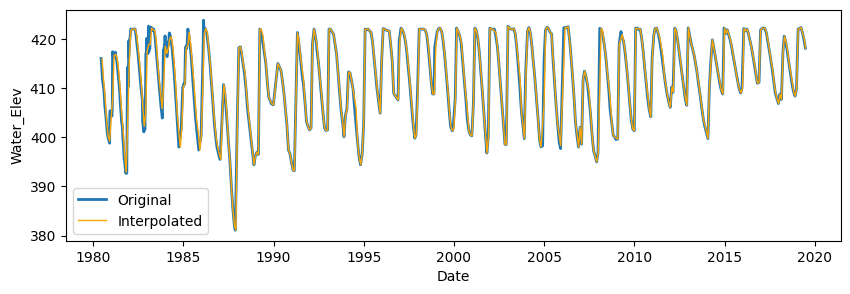

In [13]:
# Plot interpolated data in orange
sns.lineplot(x=dfs["Date"], y=dfs["Water_Elev"], label="Original", lw=2)
sns.lineplot(x=dfs_mo["Date"], y=dfs_mo["Water_Elev"], color="orange", label="Interpolated", lw=1)
plt.show()

# Stationary
The ARIMA time-series model that we are interested in assumes that the underlying data is stationary. That means the data can fluctuates, but the general trend is more or less constant. By visually studying the plot above, we see that the water elevation fluctuates seasonally; however, the overall trend is roughly constant (imagine a horizontal line drawn across the plot). The Augmented Dickey-Fuller test is one statistical test to quatify stationary of a dataset:

- Null Hypothesis (H<sub>0</sub>): Time-series data is not stationary
- Alternate Hypothesis (H<sub>1</sub>): Time-series data is not stationary

If Pearson correlation's p-value returns a value of less than a significant value, which is typically 0.05, we can reject the null hypothesis and conclude that the data is not stationary. Another way is to compare the critical values populated from the `adfuller()` module. If the 1%, 5%, and 10% critical values are greater than the ADF statistical result, we can conclude the dataset is stationary.

In [14]:
from statsmodels.tsa.stattools import adfuller

res = adfuller(dfs_mo['Water_Elev'].values)
res

(np.float64(-4.3054986985656125),
 np.float64(0.0004345730399861113),
 15,
 453,
 {'1%': np.float64(-3.444868194858831),
  '5%': np.float64(-2.867941416548597),
  '10%': np.float64(-2.5701797149735146)},
 np.float64(2523.8418544054543))

In [15]:
print(f"p-value: {res[1]:.5f} < 0.05")

print(f"ADF stat: {res[0]:.3f} < 1%: {res[4]['1%']:.3f}, 5%: {res[4]['5%']:.3f} and 10%: {res[4]['10%']:.3f}")

p-value: 0.00043 < 0.05
ADF stat: -4.305 < 1%: -3.445, 5%: -2.868 and 10%: -2.570


# Decomposition

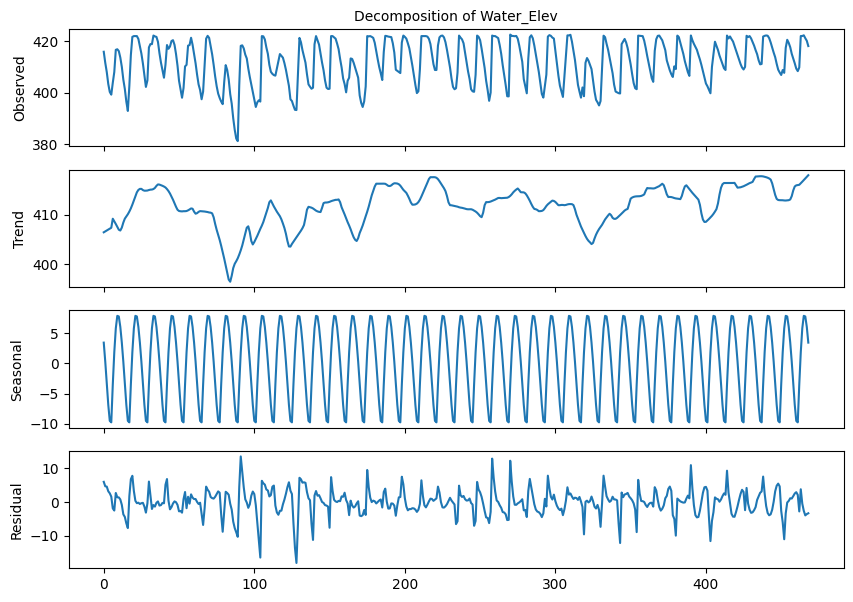

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(dfs_mo['Water_Elev'], period=12, model="additive", extrapolate_trend="freq")

# Plot decomposed time series
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(10,7))
ax[0].set_title("Decomposition of Water_Elev", fontsize=10)

decomp.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel("Observed")

decomp.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel("Trend")

decomp.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel("Seasonal")

decomp.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel("Residual")

plt.show()

In [17]:
plot_periodogram(dfs_mo["Water_Elev"])

NameError: name 'plot_periodogram' is not defined